# Kaplan-Meier Estimator

The Kaplan-Meier estimator is a non-parametric estimator of the survival function of lifetime data that can be used even in the presence of right-censoring.
This notebook illustrates how to use the Kaplan-Meier estimator provided by the `survive` package.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)

from survive import datasets
from survive.univariate import KaplanMeier

## Example 1. Leukemia Remission Times

These data are the times of remission (in weeks) of leukemia patients, taken from Table 1.1 of Cox and Oakes (1984).
Out of the 42 total patients, 21 were in a control group, and the other 21 were in a treatment group.
Patients were observed until their leukemia symptoms relapsed or until the study ended, whichever occurred first.
Each patient in the control group experienced relapse before the study ended, while 12 patients in the treatment group did not come out of remission during the study.
Thus, there is heavy right-censoring in the treatment group and no right-censoring in the control group.

The `leukemia()` function in the `survive.datasets` module loads a `pandas.DataFrame` containing these data.
The columns of this `DataFrame` are
* `time` - The patients' observed remission times (in weeks).
* `status` - Censoring indicator: 1 indicates that the patient's leukemia relapsed, and 0 indicates that the study ended before relapse.
* `group` - Indicates whether a patient is from the control or treatment group.

In [2]:
leukemia = datasets.leukemia()
display(leukemia.head())

,time,status,group
patient,,,
0,1,1,control
1,1,1,control
2,2,1,control
3,2,1,control
4,3,1,control


It is natural to question whether the treatment prolonged the patients' remission times.
The Kaplan-Meier estimator can help answer this question by estimating the survival functions of the remission times of both groups.

### Initializing the Kaplan-Meier estimator

You can initialize a `KaplanMeier` object with no parameters.

In [3]:
# Kaplan-Meier estimator to be used for the leukemia data
km_leukemia = KaplanMeier()

Now `km_leukemia` is a Kaplan-Meier estimator waiting to be fitted to survival data.
We didn't pass any parameters to the initializer of the Kaplan-Meier estimator, but we could have.
Printing a `KaplanMeier` object shows what initializer parameter values were used for that object (and default values for parameters that weren't specified explicitly).

In [4]:
print(km_leukemia)

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')


For now we'll use these default parameters.

### Fitting the estimator

We can fit our Kaplan-Meier estimator to the leukemia data using the `fit()` method.
There are two ways of doing this.
First, you can pass arrays of observed times, censoring indicators, and group labels as the `time`, `status`, and `group` parameters, respectively.
For example,

In [5]:
km_leukemia.fit(time=leukemia.time, status=leukemia.status, group=leukemia.group)

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')

Alternatively, if your data is in a `pandas.DataFrame` (like the leukemia data is), then you can pass the entire `DataFrame` itself as the `data` parameter and specify the appropriate columns by their names in the `time`, `status`, and `group` parameters.
The result is the same.

In [6]:
km_leukemia.fit(time="time", status="status", group="group", data=leukemia)

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')

### Summarizing the results

Once the estimator is fitted, the `summary()` method of a `KaplanMeier` object returns a structure containing descriptive statistics and survival tables for each group.

In [7]:
print(km_leukemia.summary())

Kaplan-Meier estimator

control

observations  events  censored  1st qu.  median  3rd qu.
                                                        
          21      21         0      4.0     8.0     12.0

time  at risk  events  survival  std. err.  95% c.i. lower  95% c.i. upper
   1       21       2  0.904762   0.064056        0.670046        0.975294
   2       19       2  0.809524   0.085689        0.568905        0.923889
   3       17       1  0.761905   0.092943        0.519391        0.893257
   4       16       2  0.666667   0.102869        0.425350        0.825044
   5       14       2  0.571429   0.107990        0.337977        0.749241
   8       12       4  0.380952   0.105971        0.183067        0.577789
  11        8       2  0.285714   0.098581        0.116561        0.481820
  12        6       2  0.190476   0.085689        0.059482        0.377435
  15        4       1  0.142857   0.076360        0.035657        0.321162
  17        3       1  0.095238   0.064056   

One of the things we can see immediately from the summary is that the estimated median remission time is much higher for the treatment group.

### Plotting estimated survival curves

The estimated survival curves for the two groups can be drawn using the `plot()` method of the `KaplanMeier` object.
By default, censored times in the sample are indicated by markers on the curve.
You can specify an optional custom sequence of colors for the groups using the `colors` parameter.

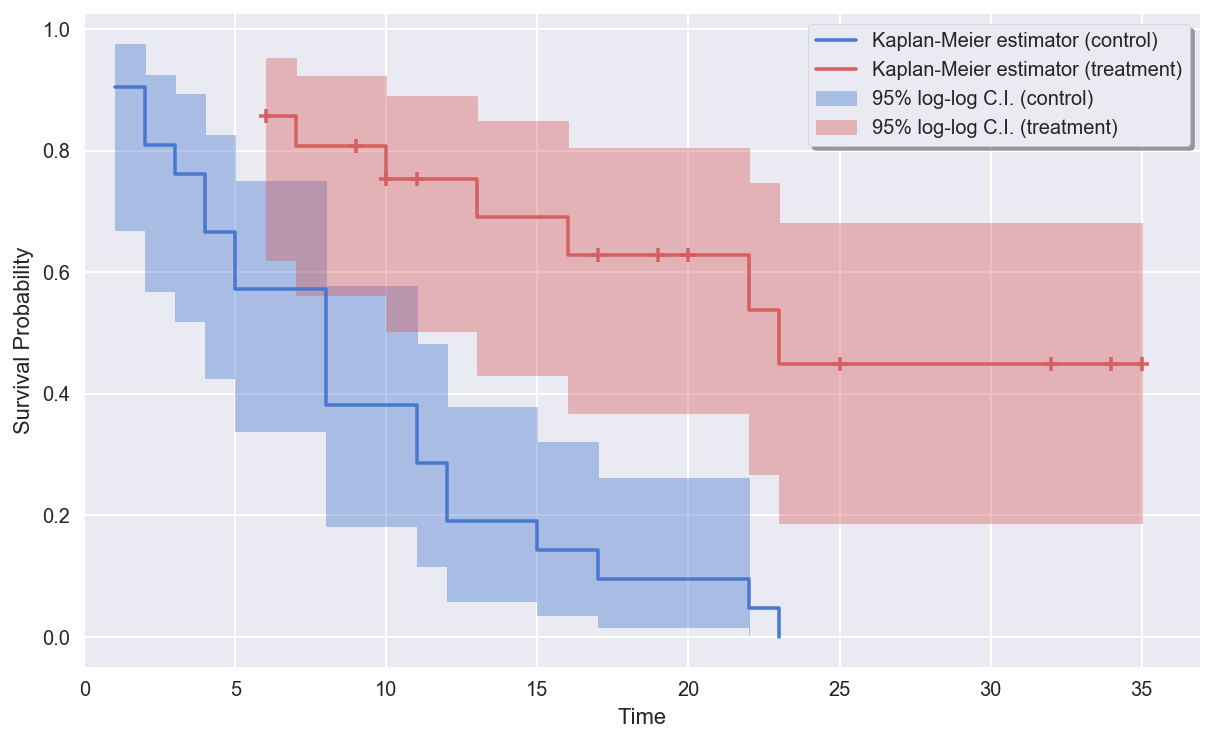

In [8]:
plt.figure(figsize=(10, 6))
km_leukemia.plot(colors=("b", "r"))
plt.show()
plt.close()

## Example 2. Channing House Data

This is the `channing` dataset in the R package [`boot`](https://cran.r-project.org/web/packages/boot/index.html).
From the package description:
>Channing House is a retirement centre in Palo Alto, California.
>These data were collected between the opening of the house in 1964 until July 1, 1975.
>In that time 97 men and 365 women passed through the centre.
>For each of these, their age on entry and also on leaving or death was recorded.
>A large number of the observations were censored mainly due to the resident being alive on July 1, 1975 when the data was collected.
>Over the time of the study 130 women and 46 men died at Channing House.
>Differences between the survival of the sexes, taking age into account, was one of the primary concerns of this study.

In [9]:
channing = datasets.channing()
channing.head()

,sex,entry,exit,time,status
resident,,,,,
0,male,782,909,127,1
1,male,1020,1128,108,1
2,male,856,969,113,1
3,male,915,957,42,1
4,male,863,983,120,1


This time, we set `conf_type="log"` when initializing the Kaplan-Meier estimator.
This specifies that confidence intervals for the survival function estimates should be derived from confidence intervals for estimates of the negative logarithm of the survival function (i.e., the *cumulative hazard function*).

In [10]:
km_channing = KaplanMeier(conf_type="log")
km_channing.fit("exit", status="status", group="sex", data=channing)

KaplanMeier(conf_level=0.95, conf_type='log', n_boot=500, random_state=None,
            tie_break='discrete', var_type='greenwood')

The `describe()` method of a `KaplanMeier` object prints a table of descriptive statistics of the estimator.

In [11]:
display(km_channing.describe())

,observations,events,censored,1st qu.,median,3rd qu.
group,,,,,,
female,365,130,235,1003.0,1056.0,1131.0
male,97,46,51,989.0,1044.0,1094.0


We separated the data into two groups by sex, and we can plot the survival curves of each group separately by specifying a group label in the call to `plot()`.
Also, since there is a lot of censoring in the data, we choose to omit the censoring markers by setting `mark_censor=False`.
Moreover, we can specify the `matplotlib.axes.Axes` on which to draw the plot using the `ax` parameter.

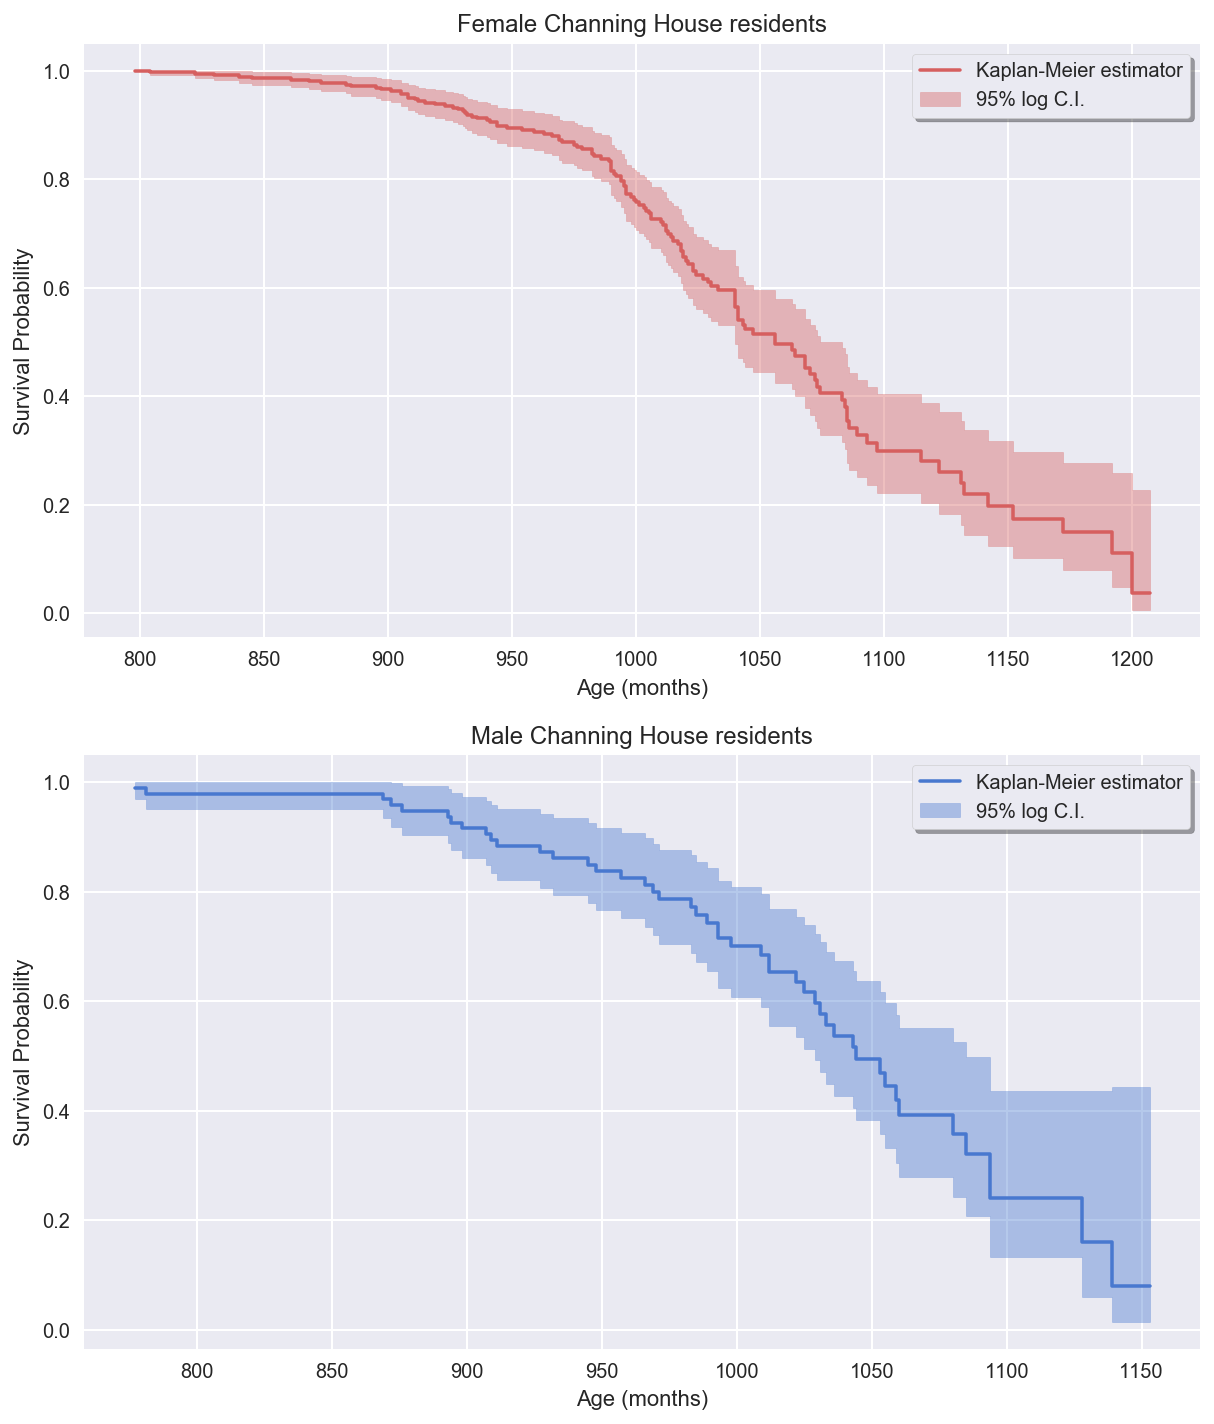

In [12]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

km_channing.plot("female", mark_censor=False, color="r", ax=ax[0])
ax[0].set(title="Female Channing House residents")
ax[0].set(xlabel="Age (months)")

km_channing.plot("male", mark_censor=False, color="b", ax=ax[1])
ax[1].set(title="Male Channing House residents")
ax[1].set(xlabel="Age (months)")

plt.show()
plt.close()

We can compare the two curves on the same plot without their confidence bands by setting `ci=False` in `plot()`.
In this plot, we pass a dictionary mapping group labels to colors as the `colors` parameter.

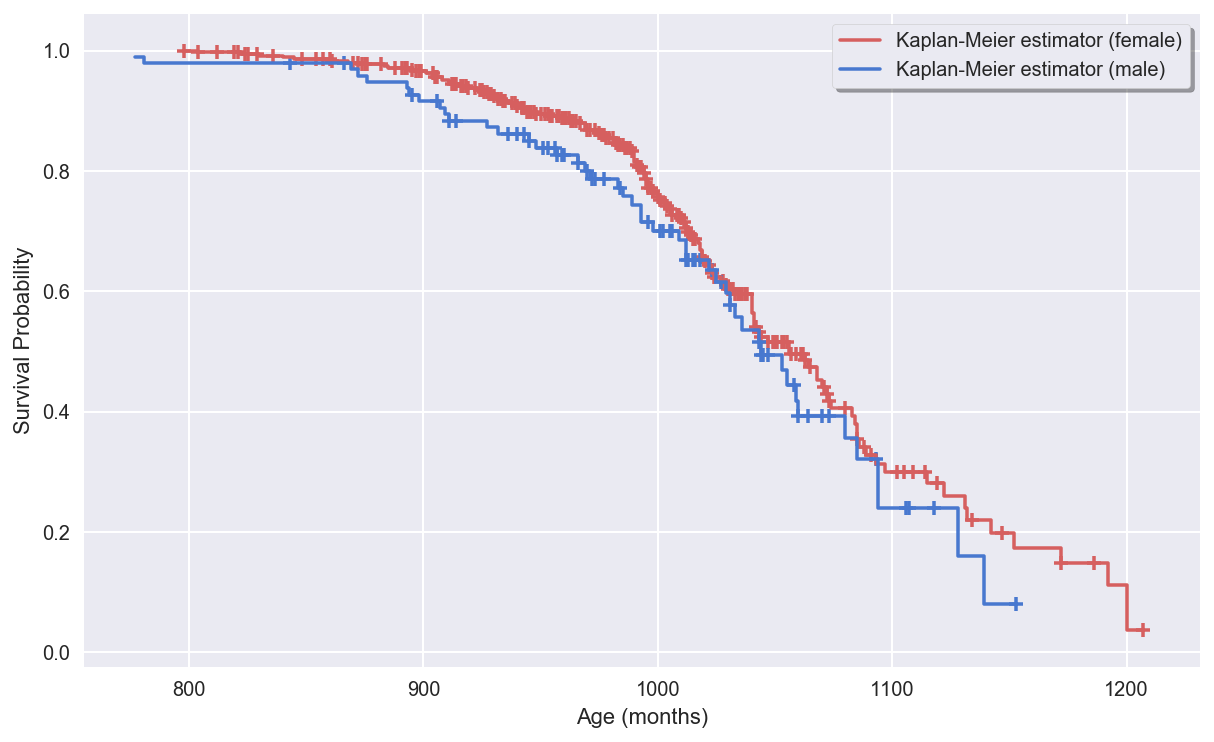

In [13]:
plt.figure(figsize=(10, 6))
km_channing.plot(ci=False, colors={"female": "r", "male": "b"})
plt.xlabel("Age (months)")
plt.show()
plt.close()

## Example 3. Simulated Gamma Data with Uniform Censoring

We generate a small sample from the gamma distribution and censor the observations with censoring times from a uniform distribution.
We know the underlying distribution (and its survival function), so it is interesting to see how well the Kaplan-Meier survival function estimate recovers the true survival function from the censored data.

In [14]:
# Underlying distribution of failure times
dist = st.gamma(a=3, scale=1)

# True failure times
failure = dist.rvs(size=50, random_state=0)

# Random censoring times
censor = st.uniform.rvs(loc=0, scale=5, size=len(failure), random_state=0)

# Observed times
time = np.minimum(failure, censor)

# Censoring indicator (0=censor, 1=failure)
status = (time == failure)

print(f"Proportion of censored data: {1 - np.mean(status):.1%}")

Proportion of censored data: 52.0%


This time we use the bootstrap for standard error estimates and ordinary normal approximation confidence intervals for the survival function estimates.

In [15]:
km = KaplanMeier(conf_type="linear", var_type="bootstrap", random_state=0)
km.fit(time, status=status)

KaplanMeier(conf_level=0.95, conf_type='linear', n_boot=500, random_state=0,
            tie_break='discrete', var_type='bootstrap')

In [16]:
display(km.describe())

,observations,events,censored,1st qu.,median,3rd qu.
group,,,,,,
0,50,24,26,1.697414,2.882889,4.043248


We plot both the true survival function and the estimated Kaplan-Meier survival function.
Looks like a decent fit despite over half the data being censored.

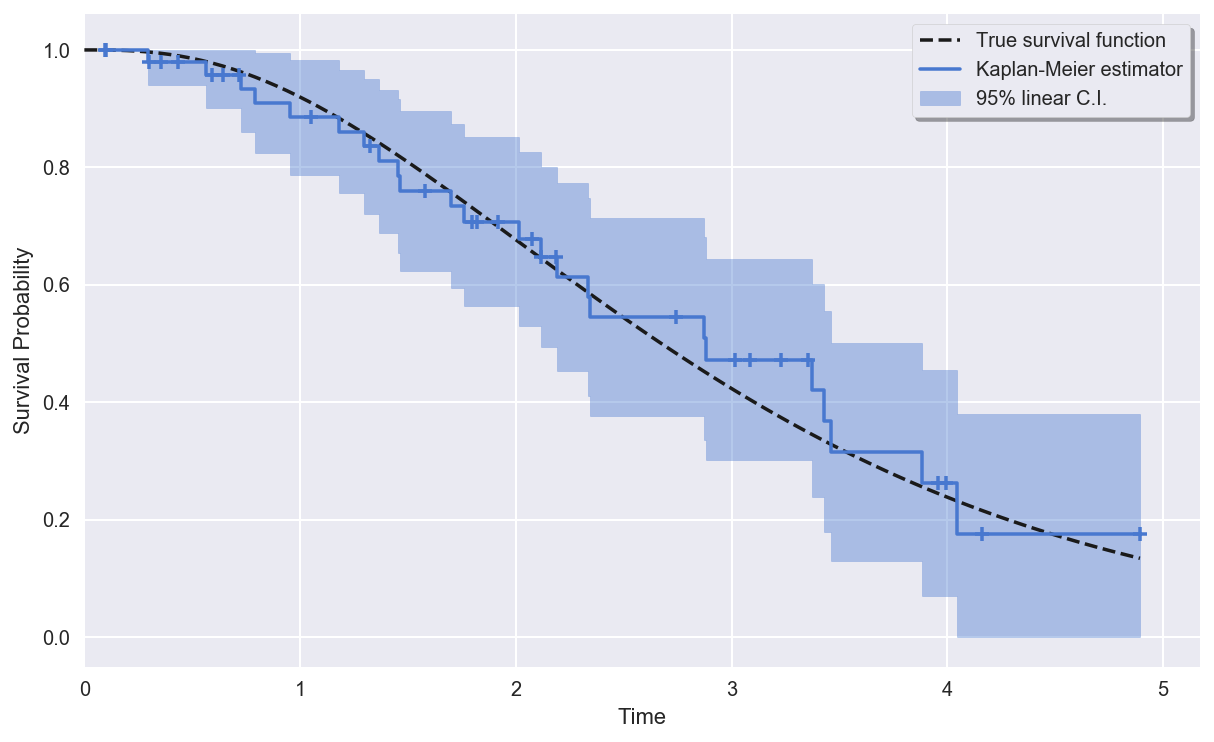

In [17]:
plt.figure(figsize=(10, 6))
x = np.linspace(0, max(time), num=100)
y = 1 - dist.cdf(x)
plt.plot(x, y, ls="--", c="k", label="True survival function")
km.plot()
plt.show()
plt.close()

## References

* E. L. Kaplan and P. Meier.
  "Nonparametric estimation from incomplete observations".
  Journal of the American Statistical Association, Volume 53, Issue 282 (1958), pp. 457--481.
  ([DOI](https://doi.org/10.2307/2281868))
* D. R. Cox and D. Oakes.
  Analysis of Survival Data.
  Chapman & Hall, London (1984), pp. ix+201.